<a href="https://colab.research.google.com/github/pedrotorres08/CNPQuniversal/blob/main/reliable_prossumer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1- Introduction**<br>
**1.1 - Definitions**<br>
*Reliable prossumer* (RP): a low-voltage prossumer connected to the microgrid (POC MG) that has both distributed generation and distributed storage, and is able to operate off-grid for a certain period. In this project, it is assumed that the distributed generation is PV, and storage is a BESS
<br>

*   $P_{MG}$ - microgrid input power
*   $P_{BESS}$ - BESS power (optimizable)
*   $P_{IN}$ - Power of inflexible, non-critical loads
*   $P_{FN}$ - Power of flexible, non-critical loads (optimizable)
*   $P_{IC}$ - Power of inflexible, critical loads
*   $P_{FC}$ - Power of flexible, critical loads (optimizable)
*   $P_{DPV}$ - Distributed PV power
<br><br>
Here we define a flexible load those that have a certain degree of flexibility in its operation scheduling on a day-ahead basis (opposing to inflexible ones) and critical loads are those that for a given day-ahead schedule MUST operate irrespective of external source availability (i.e. MG), while non-critical loads are not constrained in this regard. Load classification varies from user-specific needs, but some examples can be given:<br>
*   Inflexible, non-critical: lighting 
*   Flexible, non-critical: entertaining (TV, etc)
*   Inflexible, critical: PC + internet for home office
*   Flexible, critical: electric shower
<br><br>

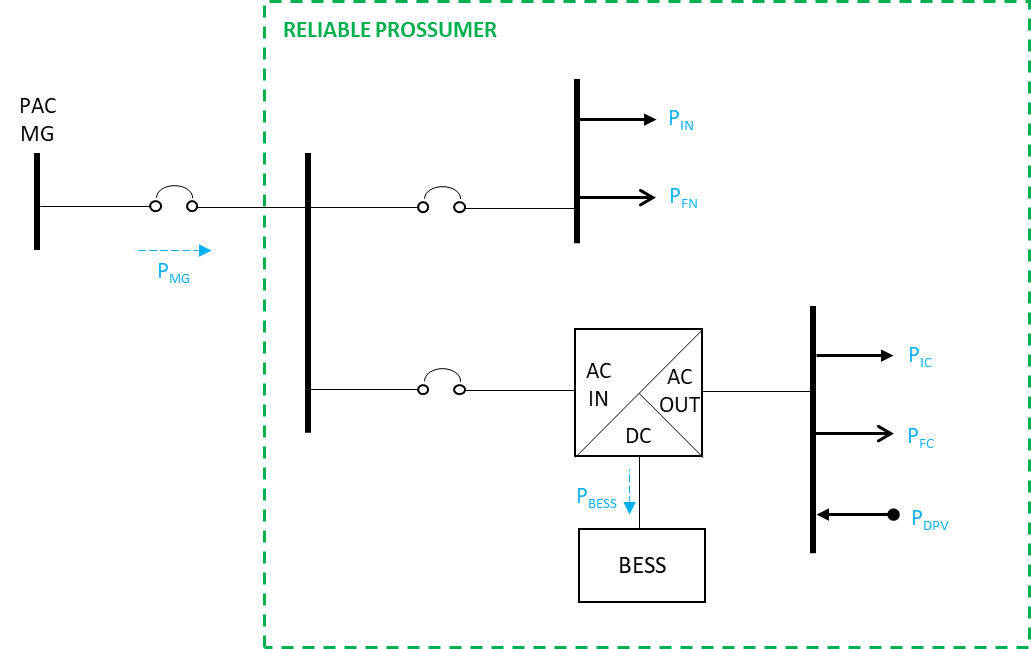
Power balance equation (time index omitted):<br>
$P_{MG}  = P_{BESS} + P_{FC} +  P_{IC} +  P_{FN} +  P_{IN} - P_{DPV}$<br>

**1.2 - Cost Function**<br>
The prossumer energy contract with the microgrid supplier is based on a day-ahead TOU tariff scheme, and also accounts the reliability of supply:
<br>
$C_{ES,t} = r_{t}*k_{t}*P_{MG,t} - p_{t}*r_{t}$<br>
Where:<br>
*   $C_{ES,t}$ - cost of energy supply, at a given time t<br>
*   $r_{t}$ - probability of guaranteed service at a given time t<br>
*   $p_{t}$ - penalty factor due unavailability of supply<br>
*   $k_{t}$ - energy supply tariff, at a given time t, in $/kWh<br>

$r_{t}$ is the probability of guaranteed service by the energy supply provider (ESP), on a TOU day-ahead basis, where $r_{t} = 1$ indicates that the ESP is 100 % confident that service will be available at a given time t in the next day. When a severe storm is forecasted, for instance, the ESP might reduce its confidence in service, thus adjusting $r_{t}$.<br>
$p_{t}$ is the penalty factor that accounts for interruptions in energy supply. This can be understood as a discount applied to the overall energy supply cost whenever service is interrupted. As $p_{t}$ is multiplied by $r_{t}$ the ESP is incentivized to determine accurate values for $r_{t}$ which in turn is an important input for the prossumer local energy scheduling.

**1.3 - Energy Management Controller**<br>
The RP energy management controller (EMC) schedules/dispatches the following variables: $P_{BESS}$, $P_{FC}$, $P_{FN}$. While $P_{DPV}$, $P_{IC}$, $P_{IN}$ are inputs that must be internally forecasted by the RP EMC. $r_{t}$, $p_{t}$ and $k_{t}$ are inputs external to the RP.

## **2 - Optimization model**
**2.1 - Cost Function**<br>
$min(\sum_{t=1}^{nt} C_{ES,t})$<br>where $nt$ is the number of timeslots for daily simulation (e.g. $nt = 24$ for an hourly timestep)<br><br>

**2.2 - Inputs**<br>
$r_{t}$, $p_{t}$, $k_{t}$, $P_{DPV,t}$, $\sum_{i=1}^{N_{IC}}P_{IC,i,t}$, $\sum_{i=1}^{N_{IN}}P_{IN,i,t}$<br>
where $N_{IN}$ is the number of inflexible, non-critical loads, and $N_{IC}$ is the number of inflexible, critical loads. <br><br>

**2.3 - Optimizing Variables**<br>
$P_{BESS,t}$, $\sum_{i=1}^{N_{FC}}P_{FC,i,t}$, $\sum_{i=1}^{N_{FN}}P_{FN,i,t}$<br>
where $N_{FN}$ is the number of flexible, non-critical loads, and $N_{FC}$ is the number of flexible, critical loads. <br><br>

**2.4 - Constraints**<br>


## **3 - Implementation**

In [2]:
#Conexao ao google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Instalar PVlib
!pip install -q pvlib

#Importar bibliotecas
import numpy as np
from scipy import signal
from scipy.optimize import minimize, Bounds
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from pvlib import pvsystem, modelchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 24.0 MB/s eta 0:00:00


In [4]:
#Definicoes iniciais
nt = 96 #Numero de timeslots
dtfv = {96: '15min', 24: '60min'}

In [5]:
#Ler Curva de Carga
filenameCCbt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_BT.parquet'
filenameCCmt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_MT.parquet'
CCbt = pd.read_parquet(filenameCCbt)
CCmt = pd.read_parquet(filenameCCmt)

CodBase = 201912371
CodCrvCrg = 'RES-Tipo1'
TipoDia = 'DU'

#Curva de carga
Pld = np.array(CCbt[(CCbt.CodBase == CodBase) & (CCbt.CodCrvCrg == CodCrvCrg) & (CCbt.TipoDia == TipoDia)].drop(columns=['Descr','CodBase','CodCrvCrg','TipoDia']).T)
Pld = [Pld[i][0] for i in range(len(Pld))]

In [6]:
#Ler Inputs
filenameINP = r'/content/drive/MyDrive/DADOS_CNPQ/cnpq_data.xlsx'
dataINP = pd.read_excel(filenameINP)

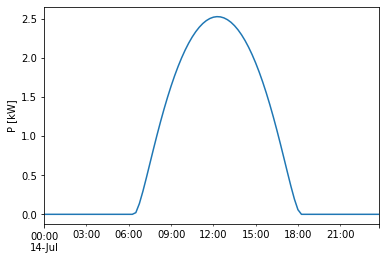

In [7]:
#Forecast FV (clear sky)
x_coord = -48
y_coord = 2
z_coord = 0
t0 = '2022-07-14 00:00'
tf = '2022-07-14 23:45'
freqfv = dtfv[nt]
gmt_fv = 'Brazil/East'

#Distributed PV generation
tilt_angle = 10
azimuth = 0
Pfv = 3.0 #Potencia em kWp
Pinv = 3.0 #Potencia em kW

loc = Location(y_coord, x_coord, gmt_fv, z_coord)
times = pd.date_range(start=t0, end=tf, freq=freqfv, tz=loc.tz)
cs = loc.get_clearsky(times)

array_kwargs = dict(module_parameters=dict(pdc0=Pfv, gamma_pdc=-0.004),temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3))
arrays = [pvsystem.Array(pvsystem.FixedMount(tilt_angle, azimuth), name='Gerador FV',**array_kwargs)]
system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=Pinv))
mc = modelchain.ModelChain(system, loc, aoi_model='physical',spectral_model='no_loss')
mc.run_model(cs)

mc.results.ac.plot(label='Pfv_CA')
plt.ylabel('P [kW]')
plt.show()

#Pdpv
Pdpv = mc.results.ac

In [ ]:
!pip install gurobipy  # install gurobipy, if not already installed

In [439]:
#Inputs
#r = 1.0*np.ones(nt) #probability of guaranteed service
#p = 2.5*np.ones(nt) #penalty factor due unavailability of supply
#k = 0.5*np.ones(nt) #energy supply tariff $/kWh
r = np.array(dataINP.r) #probability of guaranteed service
p = np.array(dataINP.p) #penalty factor due unavailability of supply
kb = np.array(dataINP.kb) #energy supply tariff $/kWh
ks = 0.1*np.ones(nt)#np.array(dataINP.ks) #energy sell tariff $/kWh
pdv = np.array(Pdpv)
pic = np.array(Pld)/max(np.array(Pld))*1.0
pin = np.array(Pld)/max(np.array(Pld))*2.0
pfc = 2.0 #Chuveiro eletrico 2 kW
pfn = 0.5 #Conjunto multimidia
SoCmx = 1.0
SoCmn = 0.2
SoC0 = 0.2
Cbat = 25 #Capacidade do BESS, em kWh
dt = 24/nt #Passo da simulacao, em horas
Pbtmx = 5 #Potencia maxima de carga da bateria, em kW
Pbtmn = -5 #Potencia maxima de descarga da bateria, em kw
alpha_soc = 1.0 #coef. angular de valoracao da confiabilidade
beta_soc = 0.0 #coef. linear de valoracao da confiabilidade

In [411]:
# Solve the following MIP:
import gurobipy as gp
from gurobipy import GRB

# Create an environment with your WLS license
params = {
"WLSACCESSID": '0e0aa6f6-cc6c-4c02-8a1f-0352f1dc962a',
"WLSSECRET": '157d1566-685f-43fe-968f-b1b1b183af7a',
"LICENSEID": 928139,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
m = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 928139
Academic license - for non-commercial use only - registered to iq22022@bristol.ac.uk


In [440]:
# Create variables
Pbat = m.addVars(range(nt),lb=float('-inf'), ub=float('inf'),vtype=GRB.CONTINUOUS)
b = m.addVars(range(nt),vtype=GRB.BINARY)
bch = m.addVars(range(nt),vtype=GRB.BINARY) #Chuveiro eletrico 1 - ON, 0 - OFF
bcm = m.addVars(range(nt),vtype=GRB.BINARY) #Conjunto multimidia 1 - ON, 0 - OFF

# Set objective function
#m.setObjective(sum([r[i]*(kb[i]*b[i] + ks[i]*(1-b[i]))*(Pbat[i]+pic[i]+pin[i]-pdv[i]) - p[i]*r[i] for i in range(nt)]), GRB.MINIMIZE);
m.setObjective(sum([r[i]*(kb[i]*b[i] + ks[i]*(1-b[i]))*(Pbat[i]+pic[i]+pin[i]+pfc*bch[i]+pfn*bcm[i]-pdv[i]) for i in range(nt)]), GRB.MINIMIZE);

# Add constraints
m.addConstrs((Pbat[i] <= Pbtmx for i in range(nt)),"PbatRangemx")
m.addConstrs((Pbat[i] >= Pbtmn for i in range(nt)),"PbatRangemn")
m.addConstrs((SoC0 + dt/Cbat*sum([Pbat[i] for i in range(j)]) <= SoCmx for j in range(nt)),"SoCmx")
m.addConstrs((SoC0 + dt/Cbat*sum([Pbat[i] for i in range(j)]) >= SoCmn for j in range(nt)),"SoCmn")
m.addConstrs((SoC0 + dt/Cbat*sum([Pbat[i] for i in range(j)]) >= alpha_soc*(pic[j]+pfc*bch[j])*(1-r[j])+beta_soc for j in range(nt)),"SoCmn-conf")
m.addConstr(sum([bch[i] for i in [1,2,3]]) == 1 ,name="chuv1")
m.addConstr(sum([bch[i] for i in [80,81,82]]) == 1 ,name="chuv2")
m.addConstr([bcm[i]+bcm[i-1]+bcm[i-2]+bcm[i-3] for i in [90,91,92,93,94]] == 4 ,name="conjm") #Da feita que liga, permanecer ligado por 1h (4x15min)

# Constants
eps = 0.0001
M = max(Pbtmx + pfc + pfn + max(pic) + max(pin), max(pdv)) + eps # smallest possible given bounds on x and y

# Model if Pbat + Pload > Pfv, then b = 1, otherwise b = 0
m.addConstrs((Pbat[i]+pic[i]+pin[i]+pfc*bch[i]+pfn*bcm[i] >= pdv[i] + eps - M * (1 - b[i]) for i in range(nt)), name="bigM_constr1")
m.addConstrs((Pbat[i]+pic[i]+pin[i]+pfc*bch[i]+pfn*bcm[i] <= pdv[i] + M * b[i] for i in range(nt)), name="bigM_constr2")

# Solve it!
m.optimize()

print(f"Optimal objective value: {m.objVal}")

Pbat = [Pbat[i].X for i in range(nt)]
b = [b[i].X for i in range(nt)]
bch = [bch[i].X for i in range(nt)]
bcm = [bcm[i].X for i in range(nt)]
Pmg = [Pbat[i] + pic[i] + pin[i] + pfc*bch[i] + pfn*bcm[i] - pdv[i] for i in range(nt)]
Emg = sum(np.array(Pmg)*0.25)

#Calcular o SoC
SoCt = []
SoCt.append(SoC0)
for j in range(1,nt):
  SoCt.append(SoCt[j-1] + Pbat[j-1]*dt/Cbat)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to iq22022@bristol.ac.uk
Optimize a model with 4048 rows, 2112 columns and 88084 nonzeros
Model fingerprint: 0x77f59fa1
Model has 204 quadratic objective terms
Variable types: 576 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [1e-02, 4e+00]
  QObjective range [3e-01, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-17, 2e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint conjm by 1.000000000

Presolve removed 10 rows and 0 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 1 (of 2 available p

AttributeError: ignored

In [437]:
np.array(bcm)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
       -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0., -0.,
       -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.])

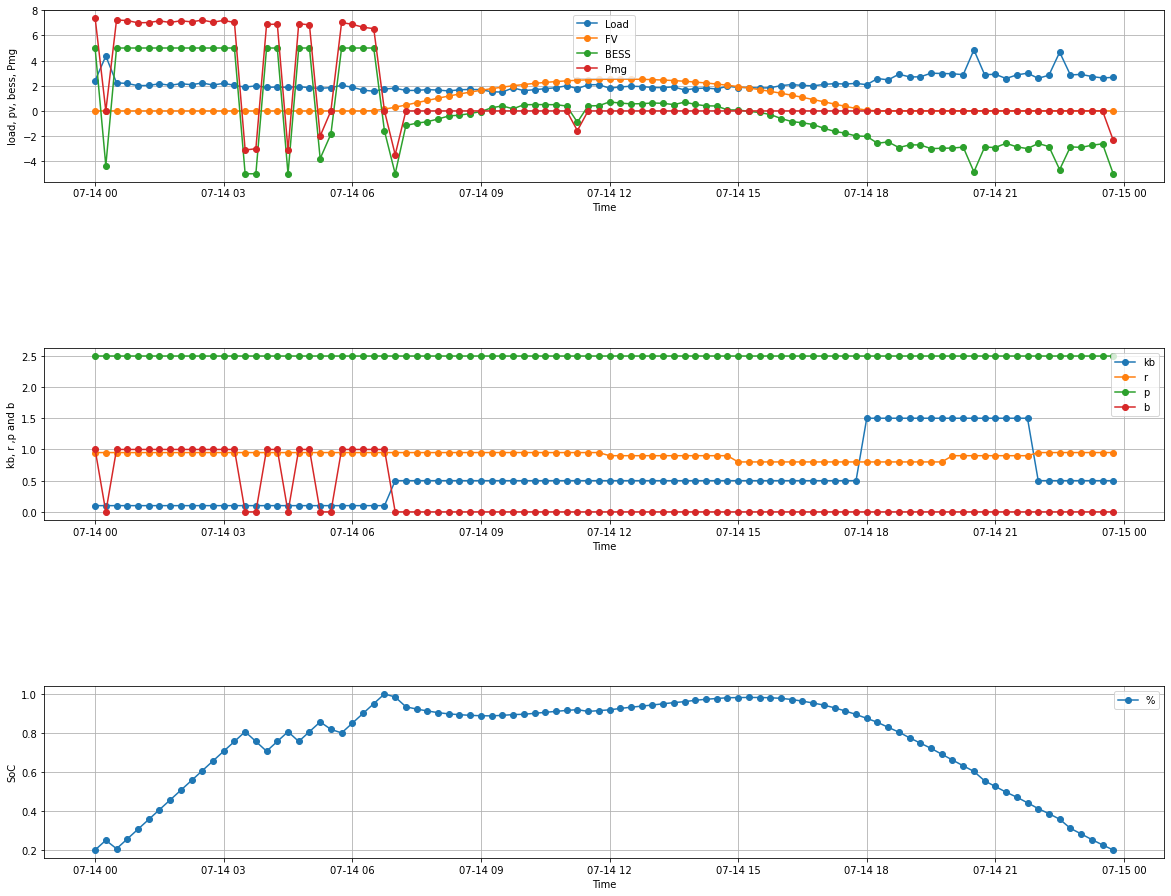

<Figure size 7200x4800 with 0 Axes>

In [435]:
#Plotar resultados
times = np.arange(np.datetime64('2022-07-14 00:00'),
                  np.datetime64('2022-07-14 23:46'), np.timedelta64(15, 'm'))

fig, axs = plt.subplots(3, 1)
axs[0].plot(times, pic+pin+pfc*np.array(bch)+pfn*np.array(bcm), times, pdv, times, Pbat, times, Pmg, marker='o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('load, pv, bess, Pmg')
axs[0].legend(['Load','FV','BESS', 'Pmg'])
axs[0].grid(True)
axs[1].plot(times, kb, times, r, times, p, times, b, marker='o')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('kb, r ,p and b')
axs[1].legend(['kb','r','p', 'b'])
axs[1].grid(True)
axs[2].plot(times, SoCt, marker='o')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('SoC')
axs[2].legend(['%'])
axs[2].grid(True)

fig.tight_layout()
plt.figure(dpi=1200)
fig.set_size_inches(18.5, 15.5)
plt.show()